# # Friends series and dialog analysis

SCENE's max used word 'apartment' 3 times, total 15
MONICA's max used word 'okay' 9 times, total 272
JOEY's max used word 'there's' 5 times, total 169
CHANDLER's max used word 'i'm' 7 times, total 110
PHOEBE's max used word 'oh' 4 times, total 81
ALL's max used word 'cut' 7 times, total 25
ROSS's max used word 'okay' 8 times, total 231
RACHEL's max used word 'i'm' 9 times, total 278
WAITRESS's max used word 'get' 1 times, total 2
PAUL's max used word 'uh' 3 times, total 67
TV's max used word 'take' 2 times, total 6
FRANNIE's max used word 'paul' 3 times, total 19


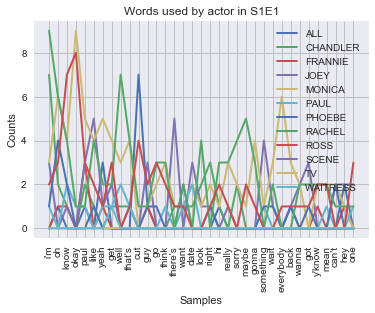

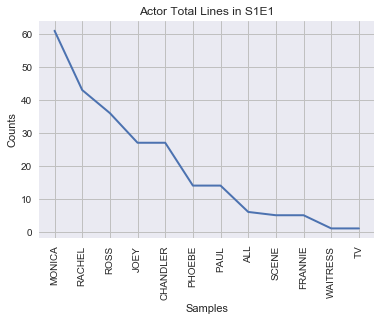

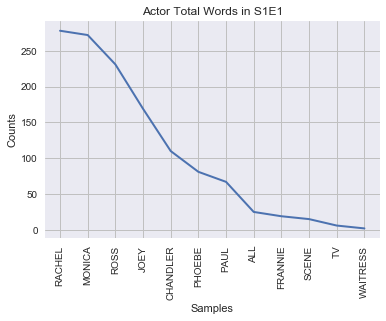

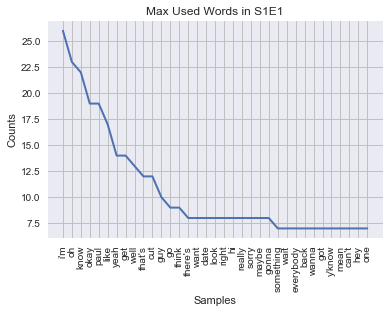

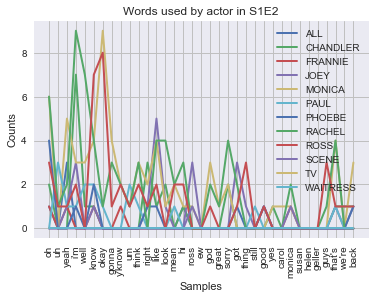

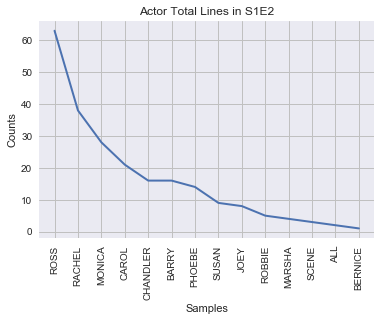

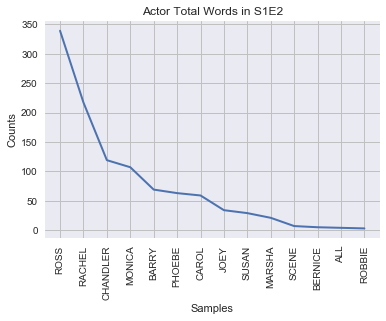

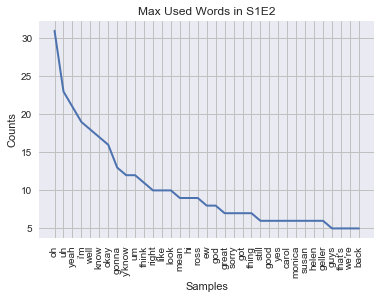

In [123]:
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize.simple import LineTokenizer
from nltk.tokenize.treebank import TreebankWordTokenizer
from nltk.tokenize import RegexpTokenizer
from nltk.probability import ConditionalFreqDist
from nltk.corpus import stopwords
import re
%matplotlib inline
sns.set()

debug = False
checkForStopWords = True
localTest = False
topN = 35

# Get English stopwords and print some of them
sw = []
if checkForStopWords:
    sw = stopwords.words('english')
    sw.append(['i', ':', 'a'])

# Print Debug statements 
def debugLine(line) :
    if debug:
        print(line)

"""
Get single episode stats for passed URL
Stats are
    freqDist - word by word count by actor
    actorLines - Count of lines by each actor 
    actorWords - Count of words by each actor
    wordCount - Total Count of each unique word used across actors
""" 
def episodeStats(url) :
    # Desired Output: In a particular episode...
    #1. Who gets the, most dialog line?... 
    actorLines = nltk.FreqDist()
    #2  most words...
    actorWords = nltk.FreqDist()
    #3. What is the most used word?
    wordCount = nltk.FreqDist()
    #4. word frequency by actor
    freqDist = ConditionalFreqDist()

    # Get the script text to process.
    text= ""
    if not localTest:
        r = requests.get(url)
        html = r.text
        soup = BeautifulSoup(html, 'html5lib')
        text = soup.get_text()
    else:
        text = """Transcript of
    The One Where Monica Gets a New Roommate
    Transcribed by guineapig
    SCENE 1: CENTRAL PERK. (ALL PRESENT EXCEPT RACHEL AND ROSS)
    MONICA: There's nothing to tell! He's just some guy I work with!
    JOEY: C'mon, you're going out with the guy! There's gotta be something wrong with him!
    CHANDLER: So does he have a hump? A hump and a hairpiece?
    PHOEBE: Wait, does he eat chalk?
    (THE OTHERS STARE, BEMUSED)
    PHOEBE: Just, 'cause, I don't want her to go through what I went through with Carl- oh!
    MONICA: Okay, everybody relax. This is not even a date. It's just two people going out to dinner and- not having sex.
    CHANDLER: Sounds like a date to me.
    (CUT TO SAME SET)
    CHANDLER: Alright, so I'm back in high school, I'm standing in the middle of the cafeteria, and I realise I am totally naked.
    ALL: Oh, yeah. Had that dream.
    """

    # Process Text and calculate stats.
    lineTokenizer = LineTokenizer()
    wordTokenizer = RegexpTokenizer(r'\w+\'*\w+|:') #TreebankWordTokenizer()

    lines = lineTokenizer.tokenize(text)
    for line in lines:
        debugLine("new line {0}".format(line))

        ### Remove all the text between openinf and closing brackets i.e. '(' and ')'
        if ('(' in line) & (')' in line):
            debugLine("line with braces --{0}".format(line))
            line = re.sub('\(.*?\)', '', line)
            debugLine("line without braces --{0}".format(line))

        words = wordTokenizer.tokenize(line)
        if len(words) > 1 :

            # If line has an actor
            if(words[1][-1] == ':'):
                debugLine("{0} says".format(words[0]))

                actor = words[0]
                actorLines[actor] += 1

                for word in words[2:]:
                    lowerCaseword = word.lower()

                    if lowerCaseword not in sw:
                        #  Record Stats
                        actorWords[actor] += 1
                        wordCount[lowerCaseword] += 1
                        freqDist[actor][lowerCaseword] += 1
                    else:
                        debugLine("ignored word {0}".format(word))
            else:
                debugLine("ignoring --{0}---".format(words[0]))
        else:
            debugLine("LINE {0}".format(line))

    return (freqDist,actorLines,actorWords,wordCount)


def getAndDrawEpisodeStats(url, episodeName, printActorTopWord=False):
    #Get Stats
    fqDist,aLines,aWords,wCount = episodeStats(url)

    if printActorTopWord:
        for actor in fqDist.conditions():
            print("{0}'s max used word '{1}' {2} times, total {3}".format(actor,fqDist[actor].max(), fqDist[actor][fqDist[actor].max()], sum(fqDist[actor].values())))

    #Draw in decending order of values
    freqDist.plot(title="Words used by actor in {0}".format(episodeName), samples=list(x for x, y in wCount.most_common(topN)))
    plt.show()

    aLines.plot(title="Actor Total Lines in {0}".format(episodeName))
    plt.show()

    aWords.plot(title="Actor Total Words in {0}".format(episodeName))
    plt.show()

    wCount.plot(topN, title="Max Used Words in {0}".format(episodeName))
    plt.show()


getAndDrawEpisodeStats('http://friends.tktv.net/Episodes1/summaries/1.html', 'S1E1', printActorTopWord=True)
getAndDrawEpisodeStats('http://friends.tktv.net/Episodes1/summaries/2.html', 'S1E2')
